# 猫狗识别
数据预处理：图像数据处理，准备训练和验证数据集

卷积网络模型：郭建网络架构

过拟合问题：观察训练和验证效果，针对你和问题提出解决方法

数据增强：图像数据增强方法与效果

迁移学习：深度学习必备训练策略

In [1]:
import os
import shutil
from shutil import copyfile
import random
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# 创建文件夹
try:
    os.mkdir('./data/PetImages/training')
    os.mkdir('./data/PetImages/testing')
    os.mkdir('./data/PetImages/training/cats')
    os.mkdir('./data/PetImages/training/dogs')
    os.mkdir('./data/PetImages/testing/cats')
    os.mkdir('./data/PetImages/testing/dogs')
except OSError:
    pass

In [3]:
# 分割猫、狗的训练集和测试集
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE): # 跳过0长度的文件
    files = []
    for filename in os.listdir(SOURCE):
        file = SOURCE + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " is zero length, so ignoring.")

    training_length = int(len(files) * SPLIT_SIZE)
    testing_length = int(len(files) - training_length)
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_length]
    testing_set = shuffled_set[-testing_length:]

    for filename in training_set:
        this_file = SOURCE + filename
        destination = TRAINING + filename
        copyfile(this_file, destination)

    for filename in testing_set:
        this_file = SOURCE + filename
        destination = TESTING + filename
        copyfile(this_file, destination)


CAT_SOURCE_DIR = "./data/PetImages/Cat/"
TRAINING_CATS_DIR = "./data/PetImages/training/cats/"
TESTING_CATS_DIR = "./data/PetImages/testing/cats/"
DOG_SOURCE_DIR = "./data/PetImages/Dog/"
TRAINING_DOGS_DIR = "./data/PetImages/training/dogs/"
TESTING_DOGS_DIR = "./data/PetImages/testing/dogs/"

def create_dir(file_dir):
    if os.path.exists(file_dir):
        print('true')
        shutil.rmtree(file_dir) # 删除再建立
        os.makedirs(file_dir)
    else:
        os.makedirs(file_dir)

# create_dir(TRAINING_CATS_DIR)
# create_dir(TESTING_CATS_DIR)
# create_dir(TRAINING_DOGS_DIR)
# create_dir(TESTING_CATS_DIR)

# split_size = .9
# split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, TESTING_CATS_DIR, split_size)
# split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, TESTING_DOGS_DIR, split_size)

In [4]:
# 打印各个文件夹里的文件个数
print(len(os.listdir('./data/PetImages/training/cats')))
print(len(os.listdir('./data/PetImages/training/dogs')))
print(len(os.listdir('./data/PetImages/testing/cats')))
print(len(os.listdir('./data/PetImages/testing/dogs')))

11250
11250
1250
1250


In [5]:
base_dir = "./data/PetImages/"

train_dir = os.path.join(base_dir, 'training')
test_dir = os.path.join(base_dir, 'testing')

# 训练集
train_dogs = os.path.join(base_dir, 'training/dogs')
train_cats = os.path.join(base_dir, 'training/cats')

# 测试集
test_dogs = os.path.join(base_dir, 'testing/dogs')
test_cats = os.path.join(base_dir, 'testing/cats')

# 构建卷积神经网络
测试阶段几层网络都可以

CPU训练，输入设置可以设置更小，一般输入的大小更主要的决定了训练速度

In [6]:
model = tf.keras.models.Sequential([
    # 如果训练慢，可以数据设置的更小一些
    # 得到filter32个特征图，卷积核3*3，默认激活层直接加relu，input_data输入大小
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    # 池化层一般都是2*2，基本不改
    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    # 为全连接层做准备
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(512, activation='relu'),
    # 二分类digmoid就够了，输出0-1之间的概率值
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [7]:
model.summary()
# 62 = (64 - 3) / 1 + 1, 32是输出个数， 896=3*3卷积核*3通道*32个卷积核+32即b值
# 池化层没权重参数，h，w变一半，个数不变
# 全连接层参数大，更容易过拟合

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 6, 6, 128)        0

配置训练器

In [12]:
model.compile(loss='binary_crossentropy',
              optimizer=Adam(lr=1e-4),
              metrics=['accuracy']
            )

In [13]:
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [14]:
train_generator = train_datagen.flow_from_directory(
    train_dir, # 文件夹路径
    target_size=(64, 64), # 指定resize层的大小
    batch_size=20,
    # 如果one_hot就是categorical，二分类用binary就可以
    class_mode='binary'
)
test_generator = test_datagen.flow_from_directory(
    test_dir, # 文件夹路径
    target_size=(64, 64), # 指定resize层的大小
    batch_size=20,
    # 如果one_hot就是categorical，二分类用binary就可以
    class_mode='binary'
)

Found 22498 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


# 训练网络模型

直接fit也可以，但是通常咱们不能把所有数据全部放入内存，fit_generator相当于一个生成器，动态产生所需的batch数据

steps_per_epoch相当给定一个停止条件，因为生成器会不断产生batch数据，说白了就是不知道一个epoch不知道执行多少次step

In [15]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=200,
    epochs=50,
    validation_data=test_generator,
    validation_steps=100,
    verbose=2
)

Epoch 1/50
200/200 - 34s - loss: 0.6894 - accuracy: 0.5397 - val_loss: 0.6630 - val_accuracy: 0.6140 - 34s/epoch - 172ms/step
Epoch 2/50
200/200 - 28s - loss: 0.6446 - accuracy: 0.6273 - val_loss: 0.6065 - val_accuracy: 0.6885 - 28s/epoch - 140ms/step
Epoch 3/50
200/200 - 26s - loss: 0.6044 - accuracy: 0.6700 - val_loss: 0.5809 - val_accuracy: 0.6900 - 26s/epoch - 132ms/step
Epoch 4/50
200/200 - 25s - loss: 0.5746 - accuracy: 0.6980 - val_loss: 0.5220 - val_accuracy: 0.7485 - 25s/epoch - 127ms/step
Epoch 5/50
200/200 - 24s - loss: 0.5347 - accuracy: 0.7253 - val_loss: 0.5485 - val_accuracy: 0.7175 - 24s/epoch - 119ms/step
Epoch 6/50
200/200 - 25s - loss: 0.4911 - accuracy: 0.7620 - val_loss: 0.4858 - val_accuracy: 0.7790 - 25s/epoch - 125ms/step
Epoch 7/50
200/200 - 30s - loss: 0.4955 - accuracy: 0.7638 - val_loss: 0.5088 - val_accuracy: 0.7580 - 30s/epoch - 150ms/step
Epoch 8/50
200/200 - 28s - loss: 0.4671 - accuracy: 0.7785 - val_loss: 0.4371 - val_accuracy: 0.8000 - 28s/epoch - 141

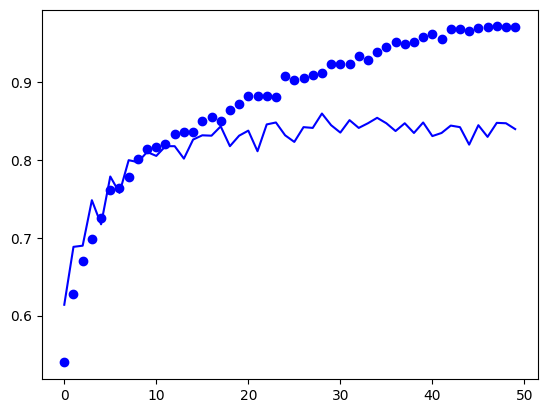

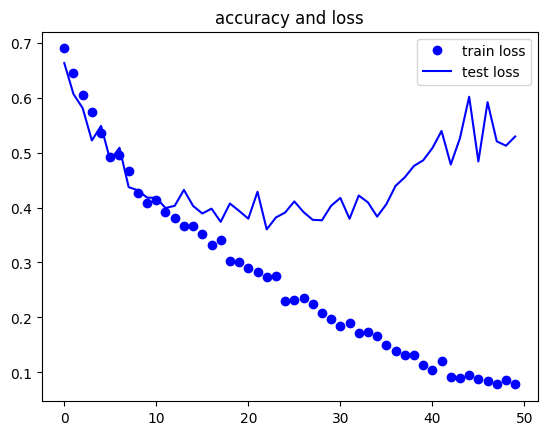

In [20]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))


plt.plot(epochs, acc, "bo", label='train accuracy')
plt.plot(epochs, val_acc, 'b', label='test accuracy')

plt.figure()
plt.plot(epochs, loss, "bo", label='train loss')
plt.plot(epochs, val_loss, 'b', label='test loss')

plt.title('accuracy and loss')
plt.legend()
plt.show()

# 测试一下加上dropouut的效果

In [21]:
model2 = tf.keras.models.Sequential([
    # 如果训练慢，可以数据设置的更小一些
    # 得到filter32个特征图，卷积核3*3，默认激活层直接加relu，input_data输入大小
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    # 池化层一般都是2*2，基本不改
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.2),
    
    # 为全连接层做准备
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(512, activation='relu'),
    # 二分类digmoid就够了，输出0-1之间的概率值
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [22]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 31, 31, 32)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 31, 31, 32)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 14, 14, 64)       

In [24]:
model2.compile(loss='binary_crossentropy',
              optimizer=Adam(lr=1e-4),
              metrics=['accuracy']
            )

In [25]:
history2 = model2.fit_generator(
    train_generator,
    steps_per_epoch=200,
    epochs=50,
    validation_data=test_generator,
    validation_steps=100,
    verbose=2
)

Epoch 1/50
200/200 - 23s - loss: 0.6959 - accuracy: 0.4935 - val_loss: 0.6927 - val_accuracy: 0.5095 - 23s/epoch - 113ms/step
Epoch 2/50
200/200 - 21s - loss: 0.6875 - accuracy: 0.5452 - val_loss: 0.6655 - val_accuracy: 0.5895 - 21s/epoch - 103ms/step
Epoch 3/50
200/200 - 20s - loss: 0.6754 - accuracy: 0.5645 - val_loss: 0.6537 - val_accuracy: 0.6275 - 20s/epoch - 99ms/step
Epoch 4/50
200/200 - 20s - loss: 0.6574 - accuracy: 0.6173 - val_loss: 0.6142 - val_accuracy: 0.6670 - 20s/epoch - 100ms/step
Epoch 5/50
200/200 - 20s - loss: 0.6227 - accuracy: 0.6543 - val_loss: 0.6379 - val_accuracy: 0.6405 - 20s/epoch - 100ms/step
Epoch 6/50
200/200 - 20s - loss: 0.5783 - accuracy: 0.6975 - val_loss: 0.5436 - val_accuracy: 0.7275 - 20s/epoch - 99ms/step
Epoch 7/50
200/200 - 20s - loss: 0.5666 - accuracy: 0.6985 - val_loss: 0.5593 - val_accuracy: 0.7055 - 20s/epoch - 100ms/step
Epoch 8/50
200/200 - 20s - loss: 0.5501 - accuracy: 0.7178 - val_loss: 0.5273 - val_accuracy: 0.7325 - 20s/epoch - 99ms/

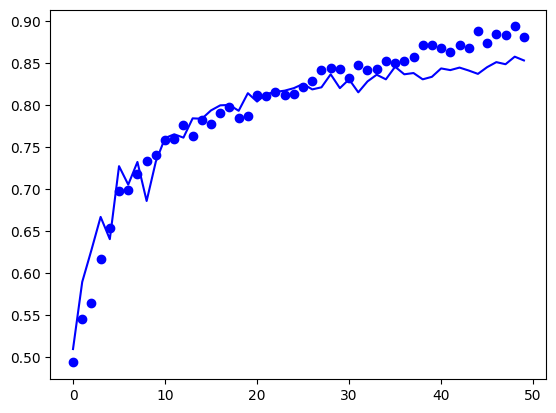

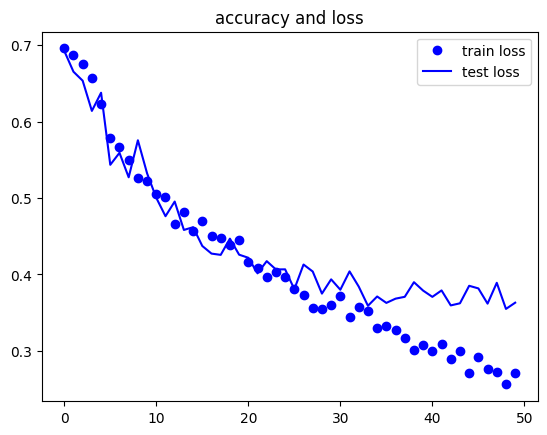

In [26]:
import matplotlib.pyplot as plt
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']
loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs = range(len(acc))


plt.plot(epochs, acc, "bo", label='train accuracy')
plt.plot(epochs, val_acc, 'b', label='test accuracy')

plt.figure()
plt.plot(epochs, loss, "bo", label='train loss')
plt.plot(epochs, val_loss, 'b', label='test loss')

plt.title('accuracy and loss')
plt.legend()
plt.show()